<div>
<img src="./images/sunpy_logo.png" width="500" align="left"/>
</div>

# An introduction to SunPy and use with Solar Orbiter! 

The `sunpy` Python package is a community-developed, free, and open-source solar data analysis environment for Python!

`sunpy` provides the core functionality and tools to analyze solar data with Python!

In this notebook we'll go through an introduction of how we can use sunpy and other scientific packages such as astropy etc to perform solar data analysis. We'll focus on how to search and query data, download data, load data into different containers, and how to plot and manipulate data.

We will show:
 1. Querying and downloading data within the sunpy ecosystem with Fido - including the SOAR!
 2. Data containers within sunpy (`Map` & `TimeSeries`)
 3. Coordinates framework


# 1. Downloading data within sunpy

## 1. 1 Overview of `Fido` Unified Downloader


* [`Fido`](https://docs.sunpy.org/en/stable/guide/acquiring_data/fido.html#fido-guide) is sunpy's interface for searching and downloading solar physics data.

* It offers a unified interface for searching and fetching data irrespective of the underlying client or webservice from where the data is obtained.

* Offers a way to search and accesses multiple instruments and all available data providers in a single query.

* It supplies a single, easy, consistent and *extendable* way to get most forms of solar physics data the community need 

Fido offers access to data available through:

 * **VSO**
 * **JSOC** (through `drms`)
 * **Individual data providers** from web accessible sources (http, ftp, etc)
 * **HEK**
 * **HELIO**
 
As described here `Fido` provides access to many sources of data through different clients, these clients can be defined inside sunpy or in other packages. Lets print the current list of available clients within sunpy.

In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.time import parse_time
import sunpy.map
import sunpy.timeseries
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord, transform_with_sun_center
import sunpy.data.sample


import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from astropy.wcs import WCS

import matplotlib.pyplot as plt
from matplotlib import colors
import glob
import numpy as np

In [2]:
Fido

<sunpy.net.fido_factory.UnifiedDownloaderFactory object at 0x11c1449d0>
sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`fido_guide`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...

### Using attributes to search for data with Fido

Sunpy uses specified **attributes** to search for data using Fido. The range of these attributes is located in the `attrs` submodule. These `attr` parameters can be combined together to construct data search queries, such as searching over a certain time period, for data from a certain instrument with a certain wavelength etc.

Different clients and provides will have client-specific attributes, but the core attributes are:

* `a.Time`
* `a.Instrument`
* `a.Wavelength`


Lets look at how these attributes work in more detail.

First we can look at `a.Time`, which is used to specify the timerange of a query.

In [3]:
a.Time("2022-03-28 11:00", "2022-03-28 14:00")

<sunpy.net.attrs.Time(2022-03-28 11:00:00.000, 2022-03-28 14:00:00.000)>

We can inspect the instrument attribute to see what instrument `attrs` are currently supported through sunpy. Here we can see the instrument name (i.e. the name to be passed to the `a.Instrument` attribute, the client from which the data is available to access, and the full name of the instrument.)

In [4]:
a.Instrument

<class 'sunpy.net.attrs.Instrument'>
sunpy.net.attrs.Instrument

Specifies the Instrument name for the search.

       Attribute Name       ...
--------------------------- ...
aia                         ...
bcs                         ...
be_continuum                ...
be_halpha                   ...
bigbear                     ...
caii                        ...
cds                         ...
celias                      ...
cerrotololo                 ...
chp                         ...
chrotel                     ...
climso                      ...
cook                        ...
costep                      ...
cp                          ...
dpm                         ...
eis                         ...
eit                         ...
elteide                     ...
erne                        ...
eui                         ...
eve                         ...
eve                         ...
film                        ...
five_12_channelmagnetograph ...
foxsi                       ...
gbm                         ...
goes                        ...
golf                        ...
gong                        ...
ha2                         ...
hi_c                        ...
hi_c21                      ...
hmi                         ...
hxeclipse                   ...
hxt                         ...
imax                        ...
impact                      ...
iris                        ...
isoon                       ...
iss                         ...
ivm                         ...
k_cor                       ...
kpdc                        ...
lasco                       ...
learmonth                   ...
longwave_lobe_06            ...
longwave_lobe_07            ...
longwave_slit_06            ...
longwave_slit_07            ...
lyra                        ...
maunaloa                    ...
mdi                         ...
mees                        ...
mergedgong                  ...
meudonspectroheliograph     ...
mk4                         ...
noaa_indices                ...
noaa_predict                ...
norh                        ...
phoenix                     ...
phoka                       ...
plastic                     ...
ptmc                        ...
rhessi                      ...
rhessi                      ...
secchi                      ...
shortwave_lobe_06           ...
shortwave_lobe_07           ...
shortwave_slit_06           ...
shortwave_slit_07           ...
six_0_ftshg                 ...
sj                          ...
solarftsspectrometer        ...
soon                        ...
sot                         ...
sp1                         ...
sp2                         ...
spectroheliograph           ...
spectromagnetograph         ...
srs_table                   ...
sufi                        ...
sumer                       ...
suvi                        ...
suvi                        ...
swan                        ...
swap                        ...
swaves                      ...
sxt                         ...
tm_1001                     ...
tm_1010                     ...
trace                       ...
udaipur                     ...
uvcs                        ...
vault_1999                  ...
vault_2002                  ...
vault_2014                  ...
virgo                       ...
vsm                         ...
wbs                         ...
wispr                       ...
x123                        ...
xrs                         ...

In [5]:
a.Instrument.eit

<sunpy.net.attrs.Instrument(EIT: Extreme ultraviolet Imaging Telescope) object at 0x12c485520>

To search for certain wavelengths, we need to specify the input as an `astropy.Quantity` which is a the combination of a value and an associated unit. This is something is universal in the sunpy stack - that every physical input/output is a `Quantity`.

In [6]:
a.Wavelength(17.1*u.nm)

<sunpy.net.attrs.Wavelength(170.99999999999997, 170.99999999999997, 'Angstrom')>

## 1.2. Constructing a search query
 ### A simple query

Lets create a simple query to search for data from AIA over a particular time period

In [7]:
result = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 14:00"), 
                     a.Instrument("AIA"))

In [8]:
result

<sunpy.net.fido_factory.UnifiedResponse object at 0x12c4900a0>
Results from 1 Provider:

174 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 488.147 Gbyte

       Start Time       ...
                        ...
----------------------- ...
2022-03-28 11:00:00.000 ...
2022-03-28 11:00:04.000 ...
2022-03-28 11:00:05.000 ...
2022-03-28 11:00:05.000 ...
2022-03-28 11:00:06.000 ...
2022-03-28 11:00:09.000 ...
2022-03-28 11:00:09.000 ...
2022-03-28 11:00:11.000 ...
2022-03-28 11:00:14.000 ...
2022-03-28 11:00:28.000 ...
2022-03-28 11:09:21.000 ...
                    ... ...
2022-03-28 13:49:30.000 ...
2022-03-28 13:49:33.000 ...
2022-03-28 13:49:40.000 ...
2022-03-28 13:59:21.000 ...
2022-03-28 13:59:23.000 ...
2022-03-28 13:59:24.000 ...
2022-03-28 13:59:26.000 ...
2022-03-28 13:59:28.000 ...
2022-03-28 13:59:29.000 ...
2022-03-28 13:59:30.000 ...
2022-03-28 13:59:33.000 ...
2022-03-28 13:59:40.000 ...
Length = 174 rows

Now lets make our query a bit more specific, say, say we only want one wavelength band from AIA. This can be achieved by specifying the `Wavelength` attribute within the search. The `a.Wavelength` attribute is passed as an `astropy.Quantity`:

In [9]:
result = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 14:00"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(304*u.angstrom))

In [10]:
result

<sunpy.net.fido_factory.UnifiedResponse object at 0x12c752400>
Results from 1 Provider:

900 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 61.01 Gbyte

       Start Time               End Time        ...   Size                              Info                          
                                                ...  Mibyte                                                           
----------------------- ----------------------- ... -------- ---------------------------------------------------------
2022-03-28 11:00:05.000 2022-03-28 11:00:06.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:00:17.000 2022-03-28 11:00:18.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:00:29.000 2022-03-28 11:00:30.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:00:41.000 2022-03-28 11:00:42.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:00:53.000 2022-03-28 11:00:54.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:01:05.000 2022-03-28 11:01:06.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:01:17.000 2022-03-28 11:01:18.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:01:29.000 2022-03-28 11:01:30.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:01:41.000 2022-03-28 11:01:42.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:01:53.000 2022-03-28 11:01:54.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 11:02:05.000 2022-03-28 11:02:06.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
                    ...                     ... ...      ...                                                       ...
2022-03-28 13:57:41.000 2022-03-28 13:57:42.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:57:53.000 2022-03-28 13:57:54.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:58:05.000 2022-03-28 13:58:06.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:58:17.000 2022-03-28 13:58:18.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:58:29.000 2022-03-28 13:58:30.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:58:41.000 2022-03-28 13:58:42.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:58:53.000 2022-03-28 13:58:54.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:59:05.000 2022-03-28 13:59:06.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:59:17.000 2022-03-28 13:59:18.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:59:29.000 2022-03-28 13:59:30.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:59:41.000 2022-03-28 13:59:42.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
2022-03-28 13:59:53.000 2022-03-28 13:59:54.000 ... 64.64844 AIA level 1, 4096x4096 [2.902 exposure] [100.00 percentd]
Length = 900 rows

In [11]:
result = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 12:00"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(304*u.angstrom),
                     a.Sample(10*u.min))

In [12]:
type(result)

sunpy.net.fido_factory.UnifiedResponse

## 1.3 Downloading the data

Now we can show how data that is queried above can be downloaded. Once the data you have searched for (and filtered etc) is constructed into a query using `Fido.search`, you can then easily download them using `Fido.fetch`.

The data is downloaded via asynchronous and parallel download streams (via parfive), and also allows for failed data downloads to be recognized so that files can be re-requested if not downloaded.

Lets now look at how a `UnifiedResponse` from a `Fido.search` can be passed to `Fido.fetch` to download the data§§§m

In [13]:
files = Fido.fetch(result)

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

In [14]:
files.errors

[]

These files are downloaded to a local location set in the sunpy.config.file, which by default is ~/sunpy/data/. Fido.fetch returns a parfile.Results object which gives the path to where the files are downloaded to

In [15]:
print(files[0])

/Users/laura.hayes/sunpy/data/aia_lev1_304a_2022_03_28t11_00_05_13z_image_lev1.fits


You can also define what directory you want the files to be saved to by passing the directory path to the path keyword in Fido.fetch. For example, I want to download these files to a local directory `./AIA/<name_of_file>`

In [16]:
Fido.fetch(result, path="./{instrument}/{file}")

Exception ignored in: <function BaseEventLoop.__del__ at 0x103e34550>
Traceback (most recent call last):
  File "/Users/laura.hayes/opt/miniconda3/envs/solo8/lib/python3.9/asyncio/base_events.py", line 688, in __del__
    self.close()
  File "/Users/laura.hayes/opt/miniconda3/envs/solo8/lib/python3.9/asyncio/unix_events.py", line 61, in close
    self.remove_signal_handler(sig)
  File "/Users/laura.hayes/opt/miniconda3/envs/solo8/lib/python3.9/asyncio/unix_events.py", line 150, in remove_signal_handler
    signal.signal(sig, handler)
  File "/Users/laura.hayes/opt/miniconda3/envs/solo8/lib/python3.9/signal.py", line 56, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter


Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

['AIA/aia_lev1_304a_2022_03_28t11_00_05_13z_image_lev1.fits', 'AIA/aia_lev1_304a_2022_03_28t11_10_05_13z_image_lev1.fits', 'AIA/aia_lev1_304a_2022_03_28t11_20_05_13z_image_lev1.fits', 'AIA/aia_lev1_304a_2022_03_28t11_30_05_15z_image_lev1.fits', 'AIA/aia_lev1_304a_2022_03_28t11_40_05_15z_image_lev1.fits', 'AIA/aia_lev1_304a_2022_03_28t11_50_05_13z_image_lev1.fits']


## 1. 4 Downloading Solar Orbiter Data: sunpy-soar

Within `sunpy` core, we support a number of clients to common data providers. However, the `Fido` search interface is extensible such that external packages can write that their own clients that extend `Fido` in order to additional data sources. One such example is the `sunpy_soar` package which adds a client for the [Solar Orbiter Archive (SOAR)](https://soar.esac.esa.int/soar/).

In [17]:
import sunpy_soar
from sunpy_soar.attrs import Product

Note that after importing `sunpy_soar`, the SOAR is now listed as a client that `Fido` will search.

In [18]:
Fido

<sunpy.net.fido_factory.UnifiedDownloaderFactory object at 0x11c1449d0>
sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`fido_guide`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...
SOARClient        ...

In [19]:
eui_query = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 14:00"), 
                       a.Instrument.eui)

In [20]:
eui_query

<sunpy.net.fido_factory.UnifiedResponse object at 0x12cc47c10>
Results from 2 Providers:

432 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 2.207 Gbyte

       Start Time               End Time        Source Instrument ...     Extent Length     Extent Type   Size  Info
                                                                  ...                                    Mibyte     
----------------------- ----------------------- ------ ---------- ... --------------------- ----------- ------- ----
2022-03-28 11:00:10.000 2022-03-28 11:00:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN  3.8125   L1
2022-03-28 11:00:10.000 2022-03-28 11:00:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 5.38281   L2
2022-03-28 11:00:15.000 2022-03-28 11:00:25.000     SO        EUI ... 13654.756761600000000    FULL_SUN 3.94434   L1
2022-03-28 11:00:15.000 2022-03-28 11:00:25.000     SO        EUI ... 13640.062310400000000    FULL_SUN 4.43262   L2
2022-03-28 11:00:45.000 2022-03-28 11:00:55.000     SO        EUI ... 13654.756761600000000    FULL_SUN 5.07031   L1
2022-03-28 11:00:45.000 2022-03-28 11:00:55.000     SO        EUI ... 13640.062310400000000    FULL_SUN 5.61426   L2
2022-03-28 11:01:10.000 2022-03-28 11:01:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN  3.8125   L1
2022-03-28 11:01:10.000 2022-03-28 11:01:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 4.94336   L2
2022-03-28 11:02:10.000 2022-03-28 11:02:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN  3.8125   L1
2022-03-28 11:02:10.000 2022-03-28 11:02:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 5.04004   L2
2022-03-28 11:03:10.000 2022-03-28 11:03:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN  3.8125   L1
                    ...                     ...    ...        ... ...                   ...         ...     ...  ...
2022-03-28 13:54:10.000 2022-03-28 13:54:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81543   L1
2022-03-28 13:54:10.000 2022-03-28 13:54:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 5.45508   L2
2022-03-28 13:55:10.000 2022-03-28 13:55:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81738   L1
2022-03-28 13:55:10.000 2022-03-28 13:55:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 5.74316   L2
2022-03-28 13:56:10.000 2022-03-28 13:56:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81738   L1
2022-03-28 13:56:10.000 2022-03-28 13:56:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 5.96875   L2
2022-03-28 13:57:10.000 2022-03-28 13:57:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81738   L1
2022-03-28 13:57:10.000 2022-03-28 13:57:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 6.01758   L2
2022-03-28 13:58:10.000 2022-03-28 13:58:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81543   L1
2022-03-28 13:58:10.000 2022-03-28 13:58:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN  6.0127   L2
2022-03-28 13:59:10.000 2022-03-28 13:59:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 3.81543   L1
2022-03-28 13:59:10.000 2022-03-28 13:59:12.000     SO        EUI ...  1007.616000000000000    FULL_SUN 6.29004   L2
Length = 432 rows

648 Results from the SOARClient:

Instrument     Data product    Level        Start time               End time        Filesize
                                                                                      Mbyte  
---------- ------------------- ----- ----------------------- ----------------------- --------
       EUI eui-hrieuv174-image    L3 2022-03-28 13:59:10.351 2022-03-29 13:59:10.351    1.247
       EUI eui-hrieuv174-image    L3 2022-03-28 13:58:10.350 2022-03-29 13:58:10.350    1.249
       EUI eui-hrieuv174-image    L3 2022-03-28 13:57:10.350 2022-03-29 13:57:10.350     1.25
       EUI eui-hrieu

In [21]:
eui_query = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 14:00"), 
                        a.soar.Product("EUI-FSI304-IMAGE"), 
                        a.Level(2))

In [22]:
eui_query

<sunpy.net.fido_factory.UnifiedResponse object at 0x12cc61df0>
Results from 1 Provider:

18 Results from the SOARClient:

Instrument   Data product   Level        Start time               End time        Filesize
                                                                                   Mbyte  
---------- ---------------- ----- ----------------------- ----------------------- --------
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:50:15.226 2022-03-28 13:50:25.226    4.654
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:40:15.226 2022-03-28 13:40:25.226    4.729
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:30:15.225 2022-03-28 13:30:25.225     4.68
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:20:15.224 2022-03-28 13:20:25.224    4.717
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:10:15.222 2022-03-28 13:10:25.222    4.709
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 13:00:15.219 2022-03-28 13:00:25.219    4.654
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:50:15.220 2022-03-28 12:50:25.220    4.715
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:40:15.220 2022-03-28 12:40:25.220     4.68
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:30:15.218 2022-03-28 12:30:25.218    4.694
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:20:15.217 2022-03-28 12:20:25.217    4.677
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:10:15.216 2022-03-28 12:10:25.216    4.732
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 12:00:15.213 2022-03-28 12:00:25.213    4.717
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:50:15.214 2022-03-28 11:50:25.214    4.735
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:40:15.213 2022-03-28 11:40:25.213    4.694
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:30:15.212 2022-03-28 11:30:25.212    4.686
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:20:15.209 2022-03-28 11:20:25.209    4.648
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:10:15.210 2022-03-28 11:10:25.210    4.703
       EUI EUI-FSI304-IMAGE    L2 2022-03-28 11:00:15.209 2022-03-28 11:00:25.209    4.648

In [23]:
f = Fido.fetch(eui_query, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/18 [00:00<?, ?file/s]

In [24]:
f[0]

'EUI/solo_L2_eui-fsi304-image_20220328T135015226_V01.fits'

We can also search for other data products, for example the Solar Orbiter MAG

In [25]:
mag_query = Fido.search(a.Time("2022-02-15", "2022-02-18"), 
                        a.soar.Product("MAG-RTN-NORMAL-1-MINUTE"), 
                        a.Level(2))

In [26]:
mag_query

<sunpy.net.fido_factory.UnifiedResponse object at 0x12cd03670>
Results from 1 Provider:

4 Results from the SOARClient:

Instrument       Data product      Level        Start time               End time        Filesize
                                                                                          Mbyte  
---------- ----------------------- ----- ----------------------- ----------------------- --------
       MAG MAG-RTN-NORMAL-1-MINUTE    L2 2022-02-18 00:00:00.000 2022-02-19 00:00:00.000     0.02
       MAG MAG-RTN-NORMAL-1-MINUTE    L2 2022-02-17 00:00:00.000 2022-02-18 00:00:00.000    0.024
       MAG MAG-RTN-NORMAL-1-MINUTE    L2 2022-02-16 00:00:00.000 2022-02-17 00:00:00.000    0.032
       MAG MAG-RTN-NORMAL-1-MINUTE    L2 2022-02-15 00:00:00.000 2022-02-16 00:00:00.000    0.033

In [27]:
ff = Fido.fetch(mag_query, path="./")

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

# 2. Data Containers


Now we have seen how we can search for and download data - lets now look at how we can read this data in.

SunPy provides core data type classes that are designed to provide a consistent interface across data types (timeseries and images) as well as data sources from numerous instruments and observations. They handle all of the manipulation necessary to read data in from mission-specific files. The two main datatypes in SunPy are

1. `TimeSeries`  
2. `Map`

## 2.1 TimeSeries

The structure of a [`TimeSeries`](https://docs.sunpy.org/en/stable/guide/data_types/timeseries.html) consists of times and measurements and the underlying structure is that of a `pandas.DataFrame`. 

SunPy TimeSeries supports time-series data from a wide range of solar-focused instruments. `TimeSeries` can either be created manually or from source files that are currently supported. If a supported file is passed to `TimeSeries` it will automatically detect its source and its instrument-specific meta data will be loaded. 

Lets create a timeseries from out sample data which is X-ray flux from the GOES X-ray Sensor Data. This data file was downloaded locally in the steps previously! 

In [28]:
xrs = sunpy.timeseries.TimeSeries(sunpy.data.sample.GOES_XRS_TIMESERIES)

<sunpy.timeseries.sources.goes.XRSTimeSeries object at 0x12ced1790>
|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2011-06-06T23:59:59.961999 | xrsa            | simple: True                                      |
|            to             | xrsb            | bitpix: 8                                         |
|2011-06-07T23:59:57.631999 |                 | naxis: 0                                          |
|                           |                 | extend: True                                      |
|                           |                 | date: 26/06/2012                                  |
|                           |                 | numext: 3                                         |
|                           |                 | telescop: GOES 15                                 |
|                           |                 | instrume: X-ray Detector                          |
|                           |                 | object: Sun                                       |
|                           |                 | origin: SDAC/GSFC                                 |
|                           |                 | ...                                               |
|-------------------------------------------------------------------------------------------------|

                                       xrsa          xrsb
2011-06-06 23:59:59.961999893  1.000000e-09  1.887100e-07
2011-06-07 00:00:02.008999944  1.000000e-09  1.834600e-07
2011-06-07 00:00:04.058999896  1.000000e-09  1.860900e-07
2011-06-07 00:00:06.104999900  1.000000e-09  1.808400e-07
2011-06-07 00:00:08.151999950  1.000000e-09  1.860900e-07
...                                     ...           ...
2011-06-07 23:59:49.441999912  1.000000e-09  1.624800e-07
2011-06-07 23:59:51.488999844  1.000000e-09  1.624800e-07
2011-06-07 23:59:53.538999915  1.000000e-09  1.598500e-07
2011-06-07 23:59:55.584999919  1.000000e-09  1.624800e-07
2011-06-07 23:59:57.631999850  1.000000e-09  1.598500e-07

[42177 rows x 2 columns]
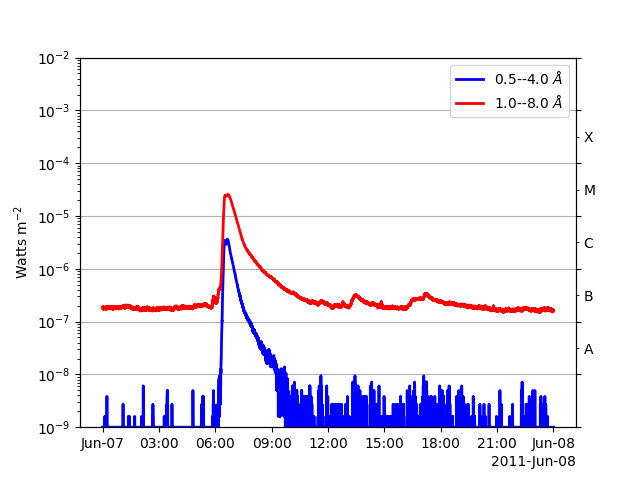

In [29]:
xrs

<AxesSubplot:ylabel='Watts m$^{-2}$'>

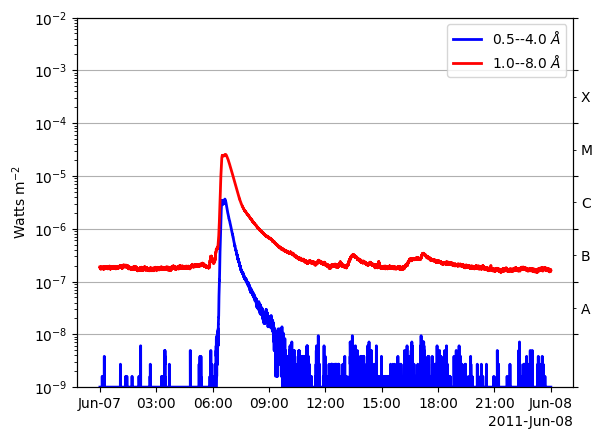

In [30]:
xrs.plot()

### Inspect the `TimeSeries`

Lets now inspect the `TimeSeries` and get at the data. A `TimeSeries` holds data as well as meta data and unit data.

In [31]:
xrs.meta

|-------------------------------------------------------------------------------------------------|
|TimeRange                  | Columns         | Meta                                              |
|-------------------------------------------------------------------------------------------------|
|2011-06-06T23:59:59.961999 | xrsa            | simple: True                                      |
|            to             | xrsb            | bitpix: 8                                         |
|2011-06-07T23:59:57.631999 |                 | naxis: 0                                          |
|                           |                 | extend: True                                      |
|                           |                 | date: 26/06/2012                                  |
|                           |                 | numext: 3                                         |
|                           |                 | telescop: GOES 15                                 |


In [32]:
xrs.units

OrderedDict([('xrsa', Unit("W / m2")), ('xrsb', Unit("W / m2"))])

In [33]:
xrs.to_dataframe()

xrsa          xrsb
2011-06-06 23:59:59.961999893  1.000000e-09  1.887100e-07
2011-06-07 00:00:02.008999944  1.000000e-09  1.834600e-07
2011-06-07 00:00:04.058999896  1.000000e-09  1.860900e-07
2011-06-07 00:00:06.104999900  1.000000e-09  1.808400e-07
2011-06-07 00:00:08.151999950  1.000000e-09  1.860900e-07
...                                     ...           ...
2011-06-07 23:59:49.441999912  1.000000e-09  1.624800e-07
2011-06-07 23:59:51.488999844  1.000000e-09  1.624800e-07
2011-06-07 23:59:53.538999915  1.000000e-09  1.598500e-07
2011-06-07 23:59:55.584999919  1.000000e-09  1.624800e-07
2011-06-07 23:59:57.631999850  1.000000e-09  1.598500e-07

[42177 rows x 2 columns]

In [34]:
xrs.to_table()

<Table length=42177>
             date               xrsa     xrsb   
                               W / m2   W / m2  
        datetime64[ns]        float32  float32  
----------------------------- ------- ----------
2011-06-06T23:59:59.961999893   1e-09 1.8871e-07
2011-06-07T00:00:02.008999944   1e-09 1.8346e-07
2011-06-07T00:00:04.058999896   1e-09 1.8609e-07
2011-06-07T00:00:06.104999900   1e-09 1.8084e-07
2011-06-07T00:00:08.151999950   1e-09 1.8609e-07
2011-06-07T00:00:10.201999903   1e-09 1.8084e-07
2011-06-07T00:00:12.248999953   1e-09 1.8609e-07
2011-06-07T00:00:14.298999906   1e-09 1.8346e-07
2011-06-07T00:00:16.344999909   1e-09 1.8084e-07
2011-06-07T00:00:18.391999960   1e-09 1.8346e-07
2011-06-07T00:00:20.441999912   1e-09 1.8084e-07
                          ...     ...        ...
2011-06-07T23:59:37.151999950   1e-09 1.6248e-07
2011-06-07T23:59:39.201999903   1e-09 1.6248e-07
2011-06-07T23:59:41.248999953   1e-09 1.5985e-07
2011-06-07T23:59:43.298999906   1e-09 1.6248e-07
2011-06-07T23:59:45.344999909   1e-09 1.5723e-07
2011-06-07T23:59:47.391999960   1e-09 1.6248e-07
2011-06-07T23:59:49.441999912   1e-09 1.6248e-07
2011-06-07T23:59:51.488999844   1e-09 1.6248e-07
2011-06-07T23:59:53.538999915   1e-09 1.5985e-07
2011-06-07T23:59:55.584999919   1e-09 1.6248e-07
2011-06-07T23:59:57.631999850   1e-09 1.5985e-07

## Manipulating the timeseries data

We can manipulate the timeseries, such as truncating (slicing) the data over a certain time period

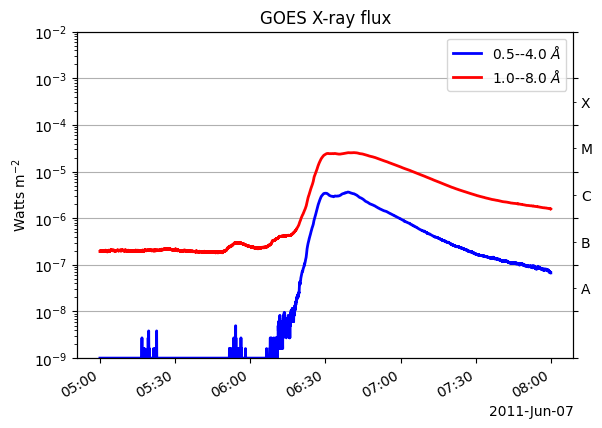

In [35]:
xrs.truncate("2011-06-07 05:00", "2011-06-07 08:00").peek()

## Solar Orbiter timeseries example

You can also pass a list of files to timeseries, and uses the `concatenate` keyword to create one continous timeseries. 

In [36]:
mag_files = glob.glob("*solo_L2_mag*.cdf")
mag_files.sort()


In [37]:
mag_files

['solo_L2_mag-rtn-normal-1-minute_20220215_V01.cdf',
 'solo_L2_mag-rtn-normal-1-minute_20220216_V01.cdf',
 'solo_L2_mag-rtn-normal-1-minute_20220217_V01.cdf',
 'solo_L2_mag-rtn-normal-1-minute_20220218_V01.cdf']

In [38]:
mag_solo = sunpy.timeseries.TimeSeries(mag_files, concatenate=True)

In [39]:
mag_solo.columns

['B_RTN_0',
 'B_RTN_1',
 'B_RTN_2',
 'QUALITY_BITMASK',
 'QUALITY_FLAG',
 'VECTOR_RANGE',
 'VECTOR_TIME_RESOLUTION']

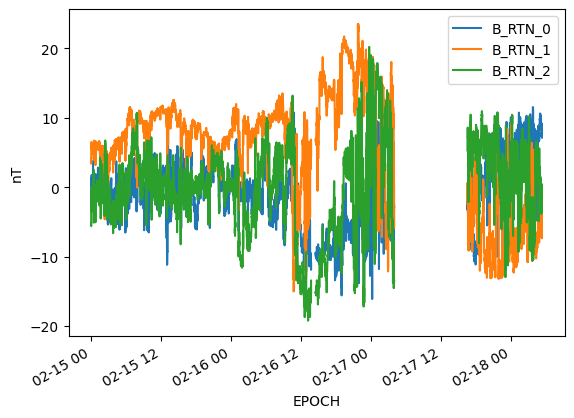

In [40]:
mag_solo.peek(['B_RTN_0', 'B_RTN_1', 'B_RTN_2'])

# 2.2 Map
The sunpy [`Map`](https://docs.sunpy.org/en/stable/guide/data_types/maps.html) class provides the data type structure to store 2-dimensional data associated with a coordinate system.  This allows users to store and manipulate images of the Sun and the heliosphere

Maps from all instruments are created using the `sunpy.map.Map` 'factory'. This class takes a wide variety of map-like inputs, for one or more maps and returns you one or many maps. All maps, irrespective of the instrument, behave the same and expose the same functions and properties, however, depending on the instrument different metadata might be read or corrections made.

In [41]:
aia_files = glob.glob("./AIA/*.fits"); aia_files.sort()

In [42]:
eui_files = glob.glob("./EUI/*.fits"); eui_files.sort()

In [43]:
eui_files[2], aia_files[2]

('./EUI/solo_L2_eui-fsi304-image_20220328T112015209_V01.fits',
 './AIA/aia_lev1_304a_2022_03_28t11_20_05_13z_image_lev1.fits')

In [44]:
aia_map = sunpy.map.Map(aia_files[2])
eui_map = sunpy.map.Map(eui_files[2])

We can easily visualize a map after loading it using the quicklook functionality.

<sunpy.map.sources.sdo.AIAMap object at 0x12cb1a520>
SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 4
Detector:		 AIA
Measurement:		 304.0 Angstrom
Wavelength:		 304.0 Angstrom
Observation Date:	 2022-03-28 11:20:05
Exposure Time:		 2.90205 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.600165 0.600165] arcsec / pix
Reference Pixel:	 [2067.137451 2005.397705] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[-1,  0, -1, ...,  0, -1,  1],
       [ 0, -1,  1, ..., -1,  1, -1],
       [ 0,  0, -1, ...,  1,  1,  1],
       ...,
       [-1, -1, -1, ...,  1,  0,  0],
       [ 0,  0, -1, ...,  1,  1,  1],
       [ 3,  2,  0, ..., -1, -1, -2]], dtype=int16)
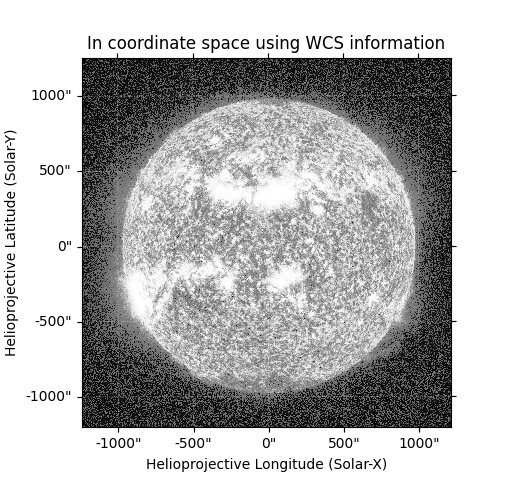
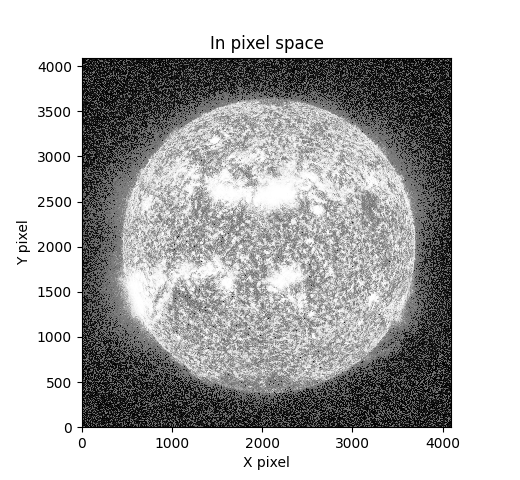
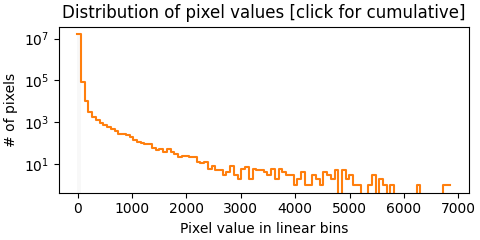
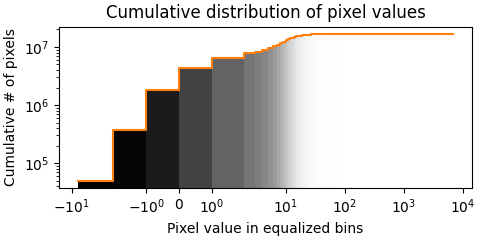

In [45]:
aia_map

`Map` provides customized loaders for a number of different instruments, however, if the data file follows the FITS data standards for coordinate information etc then map should be able to read it by default.

## Attributes of Map

`Map` provides a common interface to most 2D imaging solar datasets and provides several useful pieces of metadata. As mentioned in the intro slide, `Map` is a container for holding your data and metadata (usually from the FITS header) together.

The `.meta` and `.data` attributes provide access to the metadata and underlying array of image data, respectively.



In [46]:
aia_map.data

array([[-1,  0, -1, ...,  0, -1,  1],
       [ 0, -1,  1, ..., -1,  1, -1],
       [ 0,  0, -1, ...,  1,  1,  1],
       ...,
       [-1, -1, -1, ...,  1,  0,  0],
       [ 0,  0, -1, ...,  1,  1,  1],
       [ 3,  2,  0, ..., -1, -1, -2]], dtype=int16)

In [47]:
aia_map.meta

MetaDict([('simple', True),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('xtension', 'BINTABLE'),
          ('bld_vers', 'V9R41X'),
          ('lvl_num', 1.0),
          ('t_rec', '2022-03-28T11:20:07Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2022-04-01T06:03:19'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_4'),
          ('date-obs', '2022-03-28T11:20:05.13'),
          ('t_obs', '2022-03-28T11:20:06.58Z'),
          ('camera', 4),
          ('img_type', 'LIGHT'),
          ('exptime', 2.90205),
          ('expsdev', 0.000201),
          ('int_time', 3.148438),
          ('wavelnth', 304),
          ('waveunit', 'angstrom'),
          ('wave_str', '304_THIN'),
          ('fsn', 253115439),
          ('fid', 0),
         



However, this metadata can be terse, non-homogeneous, and sometimes difficult to parse. `Map` provides several attributes derived from the underlying raw metadata that expose a uniform interface to the metadata for each map.



In [48]:
aia_map.wavelength

<Quantity 304. Angstrom>

In [49]:
aia_map.rsun_meters

<Quantity 6.96e+08 m>

### Coordinate Information

Each `Map` also exposes information about which coordinate system the image was taken in, including the location of the spacecraft that recorded that observation.

`sunpy` leverages and extends the powerful astropy coordinate framework that we heard about in the previous tutorial. Additionally, we'll talk more about the sunpy.coordinates subpackage in the next notebook and show some neat examples.

For each `Map`, we can easily access what coordinate frame the observation cooresponds to.

In [50]:
aia_map.coordinate_frame

<Helioprojective Frame (obstime=2022-03-28T11:20:05.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-28T11:20:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.0108387, -6.7238053, 1.49323672e+11)>)>

In [51]:
aia_map.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2022-03-28T11:20:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.0108387, -6.7238053, 1.49323672e+11)>

### `Map` and WCS (World Coordinate System)

The world coordinate system (WCS) formalizes provides us a framework for transforming between pixel and world coordinates. The functionality to deal with WCS within sunpy is from the `astropy` package.




In [52]:
aia_map.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2068.137451  2006.397705  
PC1_1 PC1_2  : 0.99999735974761  0.0022979333773839  
PC2_1 PC2_2  : -0.0022979333773839  0.99999735974761  
CDELT : 0.0001667125  0.0001667125  
NAXIS : 4096  4096

In [53]:
type(aia_map.wcs)

astropy.wcs.wcs.WCS


### World and Pixel Coordinates

We can convert between the world coordinates (arcsec) to pixel coordinates using the `world_to_pixel` method on map which takes a `SkyCoord` and then returns the pixel coordinate. Similarly we can find the world coordinate to the pixel (or array) index. This is done with the `pixel_to_world` method. Lets first look at finding the array (pixel) index for the center of the Sun (0, 0) arcsec:



In [54]:
aia_map.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=aia_map.coordinate_frame))

PixelPair(x=<Quantity 2067.137451 pix>, y=<Quantity 2005.397705 pix>)

In [55]:
aia_map.pixel_to_world(0*u.pix, 0*u.pix)

<SkyCoord (Helioprojective: obstime=2022-03-28T11:20:05.130, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-28T11:20:05.130, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.0108387, -6.7238053, 1.49323672e+11)>): (Tx, Ty) in arcsec
    (-1243.37093486, -1200.68008863)>

## Visualization of `Map`

### Plotting a map

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

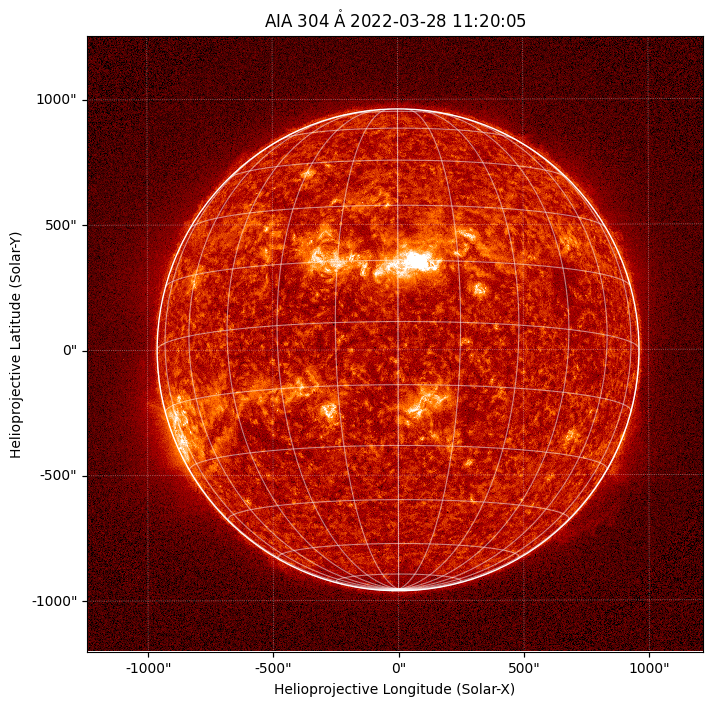

In [56]:
fig = plt.figure(figsize=(8, 8))
aia_map.plot(clip_interval=[1, 99.9]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid(color='w')

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

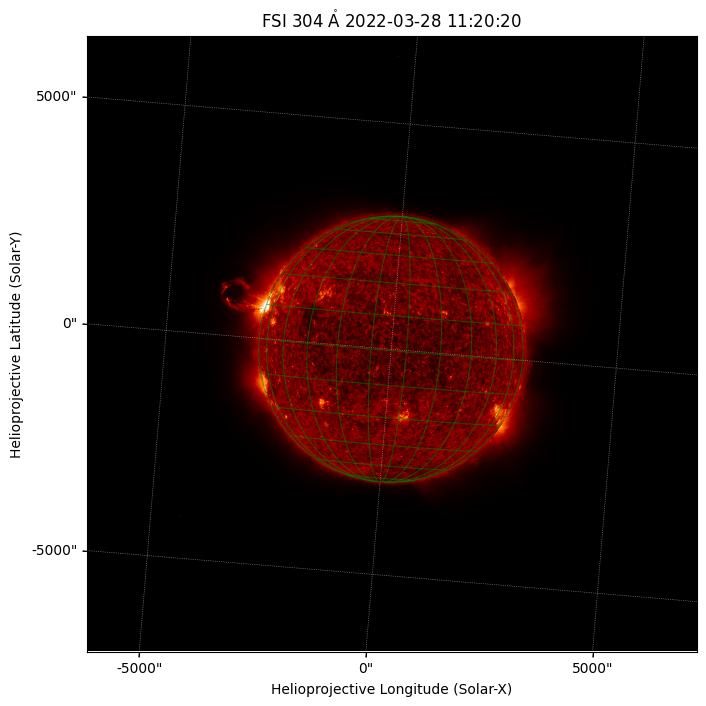

In [57]:
plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot()
eui_map.draw_grid(color='g')

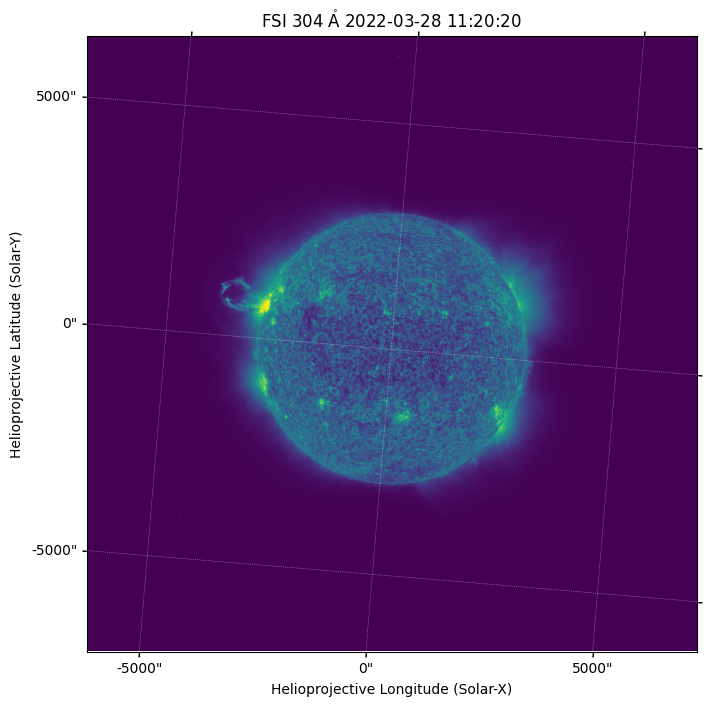

In [58]:
plt.figure(figsize=(8,8))
eui_map.plot(cmap="viridis")

## Inspecting and Manipulating the data

In [59]:
aia_map.data.shape

(4096, 4096)

In [60]:
print("Mean:", aia_map.mean(), "Max:", aia_map.max(), "Min:", aia_map.min(),  "Std:", aia_map.std())

Mean: 6.886656761169434 Max: 6850 Min: -8 Std: 22.343748149085496


### Rotate a map

The `.rotate` method applies a rotation in the image plane, i.e. about an axis out of the page. In the case where we do not specify an angle (or rotation matrix), the image will be rotated such that the world and pixel axes are aligned. In the case of an image in helioprojective coordinate system, this means that solar north will be aligned with the y-like pixel axis of the image

In [61]:
eui_map_rot = eui_map.rotate(missing=eui_map.min())

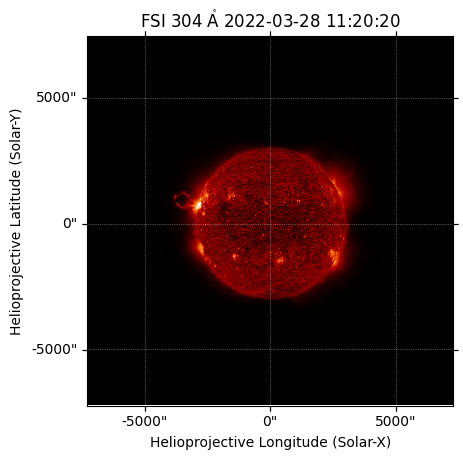

In [62]:
eui_map_rot.plot()

In [63]:
aia_map_rot = aia_map.rotate(angle=30*u.deg, missing=aia_map.min())

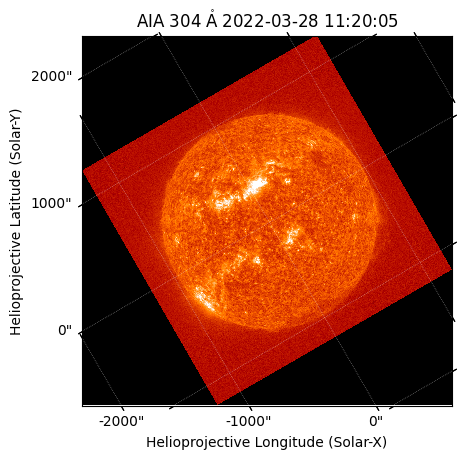

In [64]:
aia_map_rot.plot(clip_interval=[1, 99.9]*u.percent)

# Crop a map

We commonly want to pare down our full field-of-view to a particular region of interest.
With a map, we can do this using the `submap` method.

We can specify the region of our submap using world coordinates as specified by a `SkyCoord`.
These coordinates can be specified in different coordinate systems and still should work (e.g. helioprojective or heliograhic stonyhurst)

In [65]:
bottom_left = SkyCoord(-300*u.arcsec, 20*u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(390*u.arcsec, 650*u.arcsec, frame=aia_map.coordinate_frame)

In [66]:
submap = aia_map.submap(bottom_left, top_right=top_right)

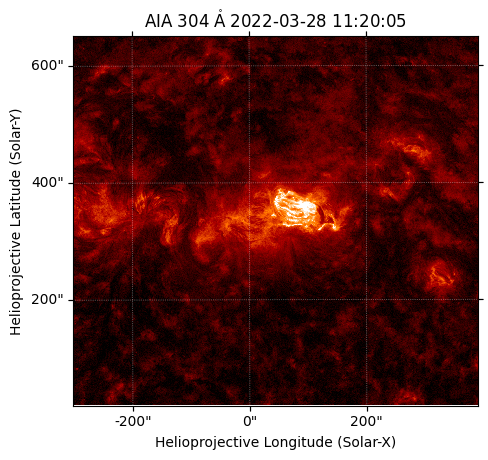

In [67]:
fig = plt.figure()
submap.plot(clip_interval=[1, 99.9]*u.percent)

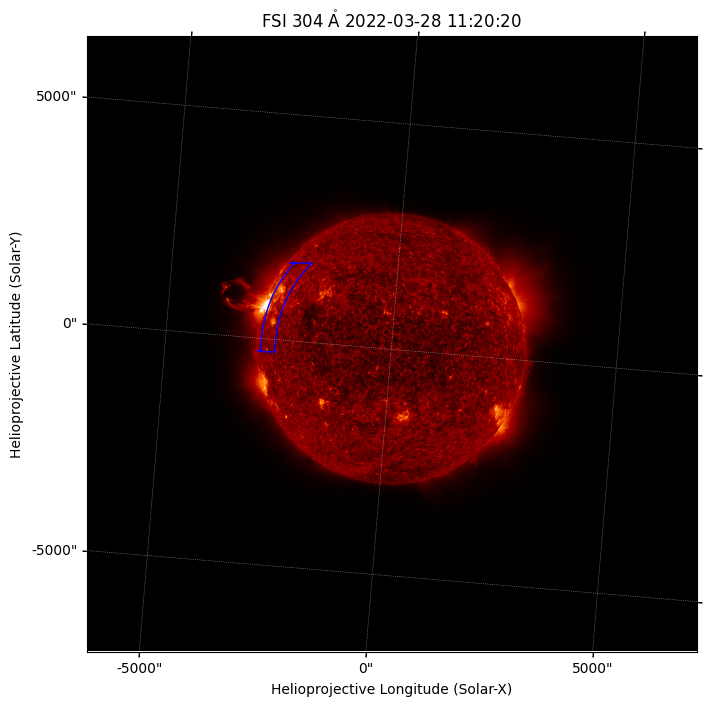

In [68]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot()
eui_map.draw_quadrangle(bottom_left, top_right=top_right, edgecolor='b')

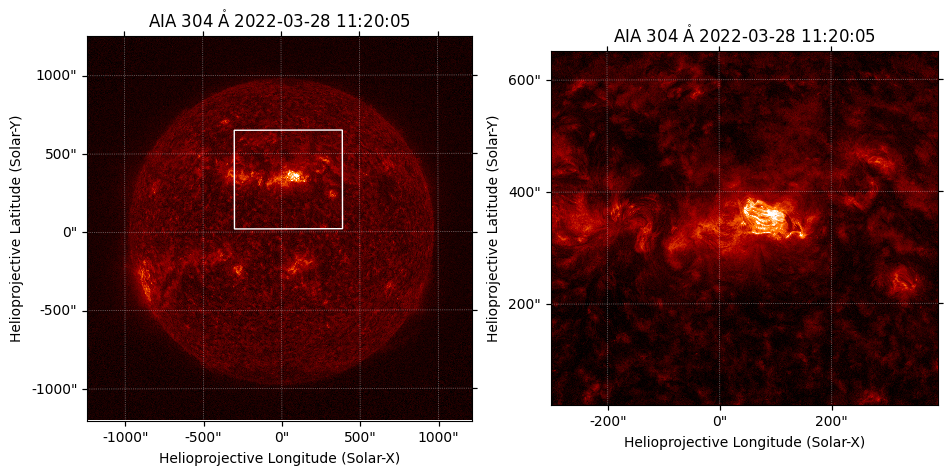

In [69]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=(0.1, 99.99)*u.percent)
# draw rectangle on the map
aia_map.draw_quadrangle(bottom_left, top_right=top_right, 
                        axes=ax1)

ax2 = fig.add_subplot(1,2,2,projection=submap)
submap.plot(clip_interval=(0.5, 99.95)*u.percent)

## WCS axes and plotting

SunPy map uses the [`astropy.visualization.wcsaxes`](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html#module-astropy.visualization.wcsaxes) module to represent world coordinates. 

Using WCSAxes is very powerful but has important concepts to think about:

 * **`world`** coordinates refer to the coordinates of the coordinate system - i.e. arcsec, degrees!
 * **`pixel`** coordinates refer to the array index of the data! i.e. data[10] etc
 
 
When plotting on WCSAxes it will by default plot in pixel coordinates, you can override this behavior and plot in `world` coordinates by getting the transformation from the axes with `ax.get_transform('world')`. We will use some of these examples below. Its also important to note that when using the `world` coordinates these have to be in **degrees** so make sure to convert arcsec's to degrees.



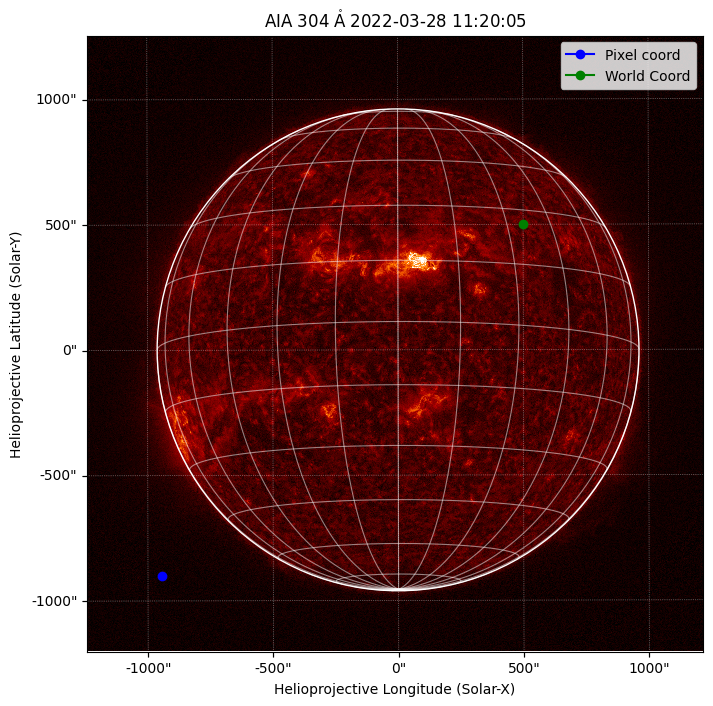

In [70]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=aia_map)  

# plot the map
aia_map.plot(clip_interval=[0.5, 99.99]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid()

# plot in pixel coordinates
ax.plot(500, 500, marker='o', color="b",  label="Pixel coord")

# plot in world coordinates
ax.plot((500*u.arcsec).to(u.deg), (500*u.arcsec).to(u.deg),
        transform=ax.get_transform('world'), 
        marker='o',color="g", label="World Coord")

ax.legend()



You can also plot SkyCoords on a Map. Importantly, this can be done with ax.plot_coord and the coordinate does not need to be transformed to the same coordinate frame as the map - it is done automatically if it can be



In [71]:
coord1 = SkyCoord(200*u.arcsec, -500*u.arcsec, frame=aia_map.coordinate_frame)
coord2 = SkyCoord(20*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst)

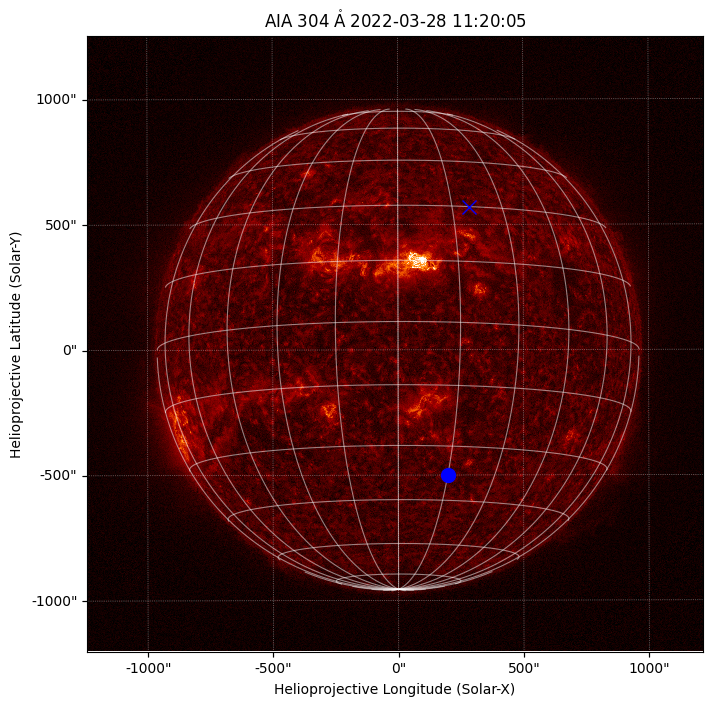

In [72]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=[0.5, 99.99]*u.percent)

aia_map.draw_grid(axes=ax)

ax.plot_coord(coord1, marker='o', ms=10, color='b')
ax.plot_coord(coord2, marker='x', ms=10, color='b')



# 3. Coordinates

SunPy uses [`astropy.coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) to represent points in physical space. This applies to both points in 3D space and projected coordinates in images.

The `sunpy.coordinates` sub-package contains:

* A robust framework for working with solar-physics coordinate systems
* Functions to obtain the locations of solar-system bodies (`sunpy.coordinates.ephemeris`)
* Functions to calculate Sun-specific coordinate information (`sunpy.coordinates.sun`)


In this notebook we'll introduce some of the powerful functionality available within sunpy

## Coordinate frameword
`sunpy` extends the `astropy.coordinates` framework by adding additional solar-specific coordinate frames and the accompanying transformations between them.

<div>
<img src="./images/coordinates.svg"/>
</div>

### Creating coordinates 

We deal with coordinates by using astropy's [`SkyCoord`](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord) class. 

We have already seem some introduction to this in the previous notebook but lets extend this here!


A **coordinate** combines position data with a coordinate frame, and a SkyCoord object is created by passing in positions with specified units and a coordinate frame. Above in the imports cell we've imported [`sunpy.coordinates.frames`](https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html#supported-coordinate-systems) which allow us to use solar physics specific frames such as Helioprojective, Heliographic Stonyhurst, Heliocentric etc. 

Lets create a point on the Sun in lat and long in the Heliographic Stonyhurst coordinate system

In [73]:
# longitude, latitude
hgs_coord = SkyCoord(10*u.deg, 20*u.deg, obstime="2017-08-01", frame=frames.HeliographicStonyhurst)  
hgs_coord

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (lon, lat) in deg
    (10., 20.)>

In [74]:
hgs_coord_xyz = SkyCoord(hgs_coord, representation_type='cartesian')
hgs_coord_xyz

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (x, y, z) [dimensionless]
    (0.92541658, 0.16317591, 0.34202014)>

We can then transform this coordinate to the any defined coordinate frame defined in astropy or sunpy. Lets transform it to the Helioprojective frame (which is observer-based)

In [75]:
hgs_coord.transform_to(frames.Helioprojective(observer="earth"))

<SkyCoord (Helioprojective: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (154.89224085, 234.48634082, 1.51172864e+08)>

We can also convert this to other coordinate systems outside the solar-specific ones - for examples ICRS

In [76]:
hgs_coord.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (16.45495249, 16.01388665, 980067.1475033)>

## An important note about observer based frames

Some coordinate frames are defined based on the position of the observer e.g. the Helioprojective and Heliocentric frames. Hence it's important to think about this - particularly when transforming points between coordinate systems. 
This is shown above when transforming to Helioprojective we needed to pass an `observer` keyword. Similarly, its important that the `obstime` is given also!

For example, lets define a point on the Sun in Helioprojective and see what that equivalent point would be from another observer - say Mars!

In [77]:
obstime = "2022-05-02 00:00"

In [78]:
hpc_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, observer="earth", 
                     obstime=obstime, frame=frames.Helioprojective)
hpc_coord

<SkyCoord (Helioprojective: obstime=2022-05-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty) in arcsec
    (0., 0.)>

In [79]:
print(hpc_coord.Tx, hpc_coord.Ty)

0arcsec 0arcsec


In [80]:
mars_hpc_coord = hpc_coord.transform_to(frames.Helioprojective(observer="mars"))
mars_hpc_coord

<SkyCoord (Helioprojective: obstime=2022-05-02T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'mars'>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-678.66522024, -54.34326175, 1.39871439)>

In [81]:
print(mars_hpc_coord.Tx, mars_hpc_coord.Ty)

-678.665arcsec -54.3433arcsec


# Observations from different observer locations

## Example of SDO/AIA and Solar Orbiter/EUI

<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

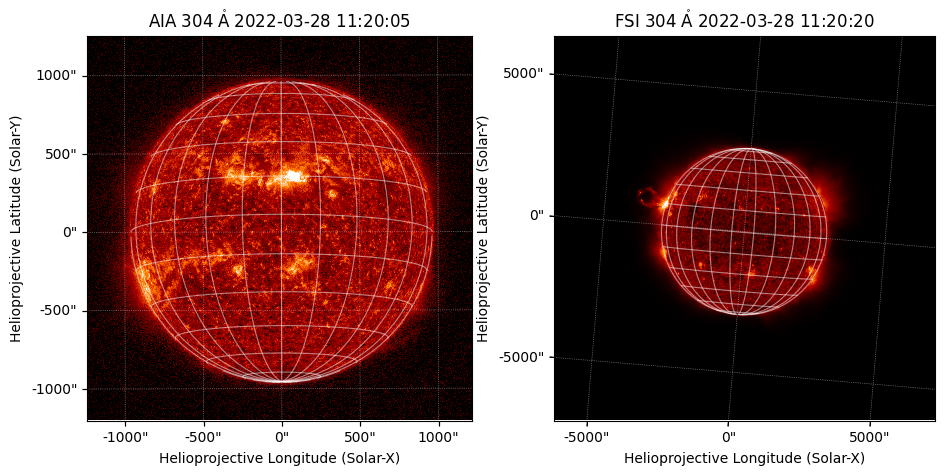

In [82]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
ax2 = fig.add_subplot(1,2,2,projection=eui_map)

aia_map.plot(vmin=0, vmax=200, axes=ax1)
aia_map.draw_grid()
eui_map.plot(axes=ax2)
eui_map.draw_grid()

### Plot the solar limb as seen from EUI on AIA map

We can plot the solar limb as seen from EUI on the AIA map

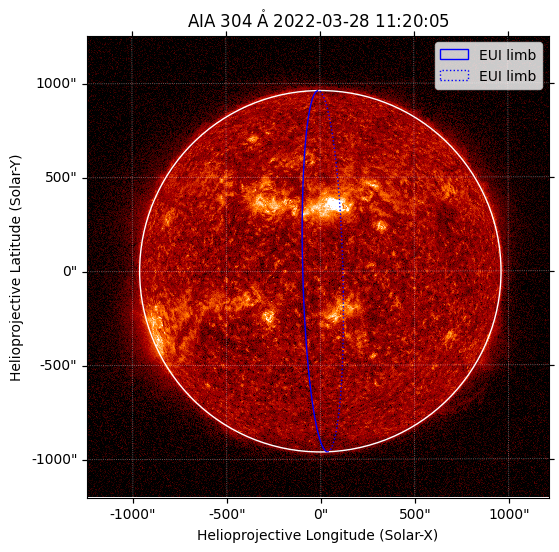

In [83]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax1, vmin=0, vmax=200)
aia_map.draw_limb(axes=ax1, color='white')
eui_map.draw_limb(axes=ax1, color='blue', label="EUI limb")
plt.legend()

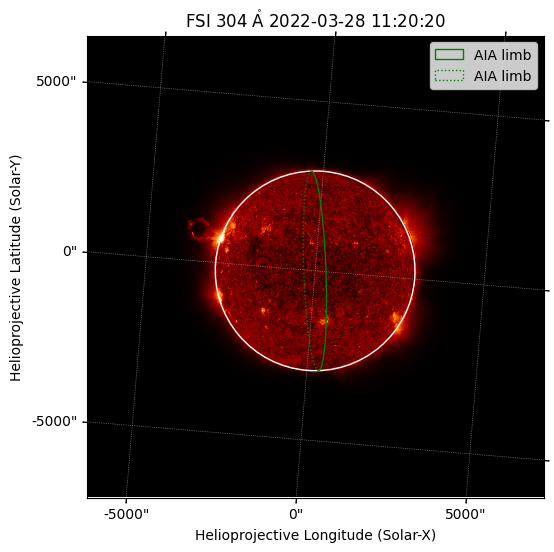

In [84]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=eui_map)
eui_map.plot(axes=ax1)
eui_map.draw_limb(axes=ax1, color='white')
aia_map.draw_limb(axes=ax1, color='green', label="AIA limb")
plt.legend()



## The solar flare and eruption is both seen by SDO/AIA and from SolO/EUI, just from two different points of view.

Lets define the point and plot the point of the flare as seen by AIA

In [85]:
flare_coord_aia = SkyCoord(100*u.arcsec, 350*u.arcsec, frame=aia_map.coordinate_frame)

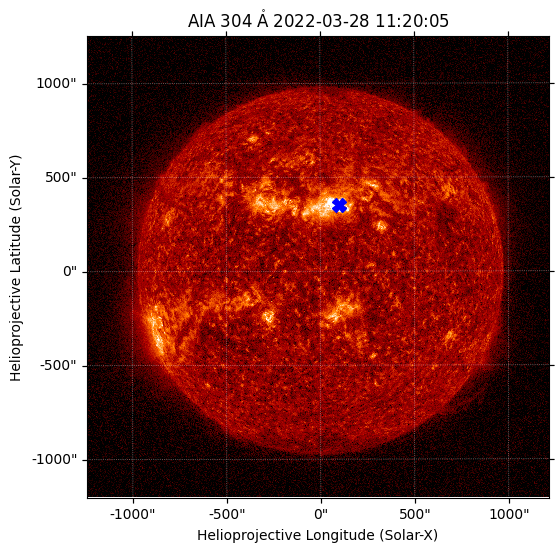

In [86]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(vmin=0, vmax=200)
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

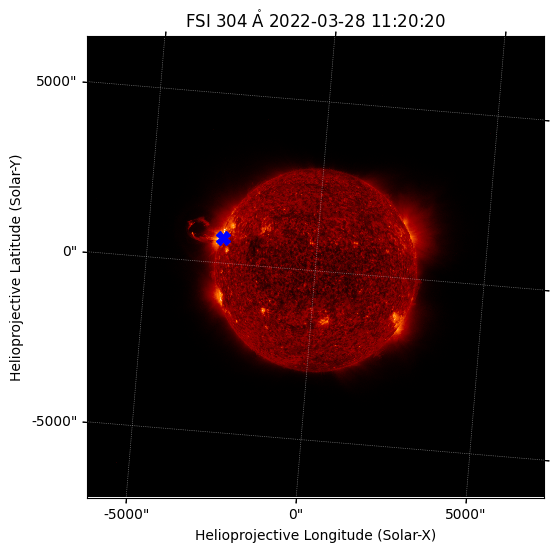

In [87]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot()
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

## Reproject AIA to field of view of Solo

Lets say for this observation, we want to identify what the AIA field of view looks like from the observer of Solar Orbiter. We can do this by using `reproject`.

In [88]:
aia_map = aia_map.resample((512, 512)*u.pix)

In [89]:
outshape = (1500, 1500)# aia_map.data.shape
ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                     frame='helioprojective', obstime=eui_map.date, observer=eui_map.observer_coordinate)

# Create a FITS WCS header for the reference coordinate and frame
header = sunpy.map.make_fitswcs_header(
    outshape,
    ref_coord,
    scale=u.Quantity(aia_map.scale),
)
header['rsun_ref'] = aia_map.meta['rsun_ref']



In [90]:
outmap = aia_map.reproject_to(header)
outmap.plot_settings = aia_map.plot_settings

Text(0.5, 1.0, 'AIA from view of Solar Orbiter')

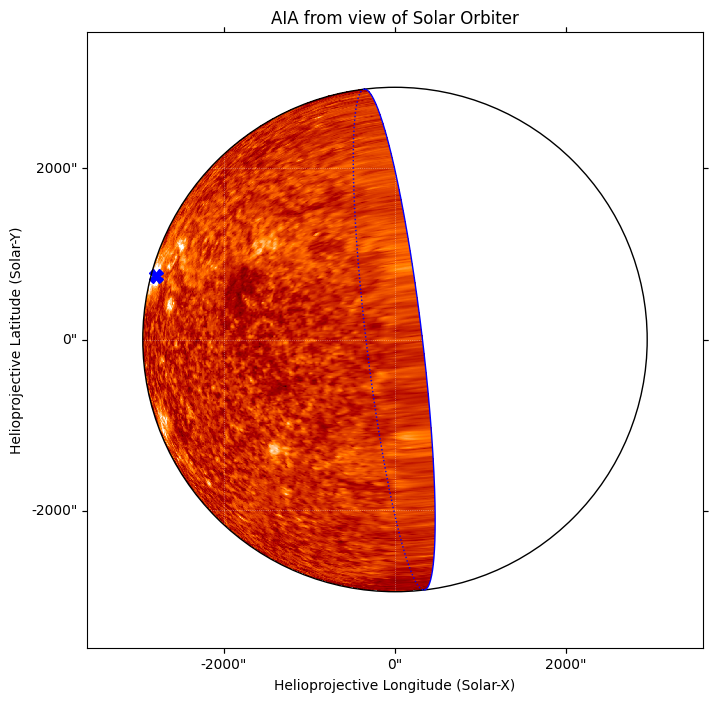

In [91]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=outmap)
outmap.plot(vmin=0, vmax=100)
outmap.draw_limb(color='k')
aia_map.draw_limb(color='b')
ax.plot_coord(flare_coord_aia, color='b', marker='X', ms=10)
ax.set_title("AIA from view of Solar Orbiter")

## Reproject to Heliographic Maps

As well as reprojecting to different observers, sunpy maps can also be reprojected to different coordinate frames`

In [92]:
shape_out = (720, 1440)
frame_out = SkyCoord(0, 0, unit=u.deg,
                     frame="heliographic_stonyhurst",
                     obstime=aia_map.date,
                     rsun=aia_map.coordinate_frame.rsun)
header = sunpy.map.make_fitswcs_header(shape_out,
                                       frame_out,
                                       scale=(360 / shape_out[1],
                                              180 / shape_out[0]) * u.deg / u.pix,
                                       projection_code="CAR")
out_wcs = WCS(header)

In [93]:
outmap = aia_map.reproject_to(header)

(<matplotlib.patches.Polygon at 0x12dbd4730>, None)

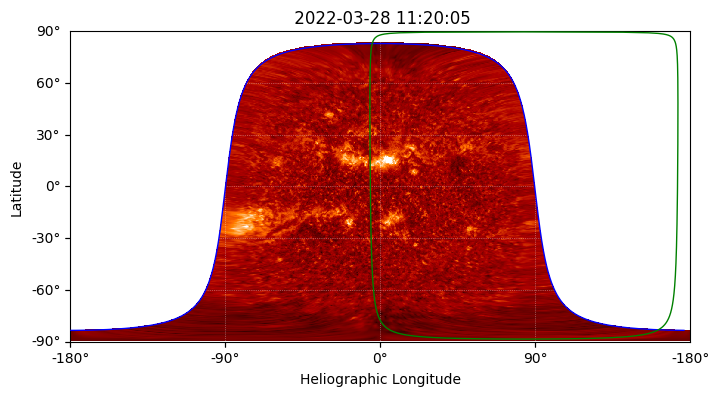

In [94]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection=outmap)
outmap.plot(vmin=0, vmax=200)
aia_map.draw_limb(color='b')
eui_map.draw_limb(color='green')

## Positions of solar system bodies
`sunpy.coordinates` provides functions to obtain the coordinates of solar-system bodies.
The function `get_body_heliographic_stonyhurst` which will return the location of the solar-system body in the `HeliographicStonyhurst` frame.

For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use `get_horizons_coord()`, which queries JPL HORIZONS:

In [95]:
earth_pos = get_body_heliographic_stonyhurst("earth", "2022-03-28")
mars_pos = get_body_heliographic_stonyhurst("mars", "2022-03-28")

In [96]:
print(mars_pos)

<HeliographicStonyhurst Coordinate (obstime=2022-03-28T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (95.99972347, 1.85057145, 1.43001534)>


In [97]:
solo_pos = get_horizons_coord("solar orbiter", "2022-03-28")

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


## Plotting positions of spacecraft

Lets plot the positions of different spacecraft over the recent Solar Orbiter perihelion!

In [98]:
perihelion_time = parse_time("2022-03-26")
perihelion_seq = perihelion_time + np.arange(-30, 30)*u.day



In [99]:
solo_coord = get_horizons_coord("solar orbiter", perihelion_seq)
psp_coord = get_horizons_coord("psp", perihelion_seq)
sdo_coord = get_horizons_coord("sdo", perihelion_seq)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


In [100]:
solo_coord

<SkyCoord (HeliographicStonyhurst: obstime=['2022-02-24T00:00:00.000' '2022-02-25T00:00:00.000'
 '2022-02-26T00:00:00.000' '2022-02-27T00:00:00.000'
 '2022-02-28T00:00:00.000' '2022-03-01T00:00:00.000'
 '2022-03-02T00:00:00.000' '2022-03-03T00:00:00.000'
 '2022-03-04T00:00:00.000' '2022-03-05T00:00:00.000'
 '2022-03-06T00:00:00.000' '2022-03-07T00:00:00.000'
 '2022-03-08T00:00:00.000' '2022-03-09T00:00:00.000'
 '2022-03-10T00:00:00.000' '2022-03-11T00:00:00.000'
 '2022-03-12T00:00:00.000' '2022-03-13T00:00:00.000'
 '2022-03-14T00:00:00.000' '2022-03-15T00:00:00.000'
 '2022-03-16T00:00:00.000' '2022-03-17T00:00:00.000'
 '2022-03-18T00:00:00.000' '2022-03-19T00:00:00.000'
 '2022-03-20T00:00:00.000' '2022-03-21T00:00:00.000'
 '2022-03-22T00:00:00.000' '2022-03-23T00:00:00.000'
 '2022-03-24T00:00:00.000' '2022-03-25T00:00:00.000'
 '2022-03-26T00:00:00.000' '2022-03-27T00:00:00.000'
 '2022-03-28T00:00:00.000' '2022-03-29T00:00:00.000'
 '2022-03-30T00:00:00.000' '2022-03-31T00:00:00.000'
 '2

Text(0.5, 1.0, 'Positions in Heliographic Stonyhurst (HGS)')

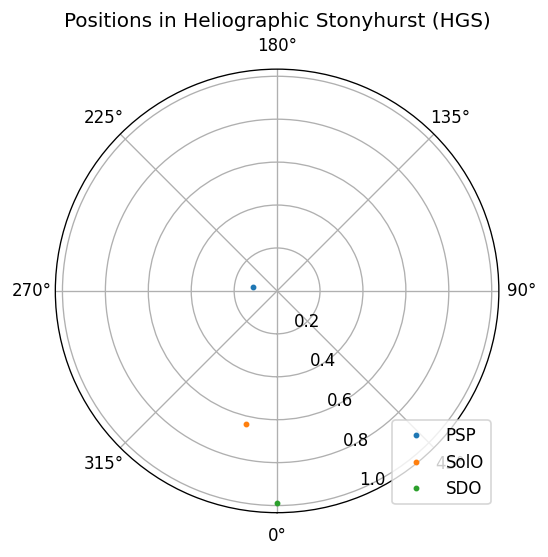

In [101]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='polar')

# Transform to HGS
psp_coord_hgs = psp_coord[0].heliographic_stonyhurst
solo_coord_hgs = solo_coord[0].heliographic_stonyhurst
sdo_coord_hgs = sdo_coord[0].heliographic_stonyhurst


ax.plot(psp_coord_hgs.lon.to('rad'), psp_coord_hgs.radius,
        '.', markersize=5, label='PSP')
ax.plot(solo_coord_hgs.lon.to('rad'), solo_coord_hgs.radius,
        '.', markersize=5, label='SolO')
ax.plot(sdo_coord_hgs.lon.to('rad'), sdo_coord_hgs.radius,
        '.', markersize=5, label='SDO')


ax.legend(loc='lower right')
ax.set_theta_zero_location("S")
ax.set_title('Positions in Heliographic Stonyhurst (HGS)')

Text(0.5, 1.0, 'Positions in Heliographic Stonyhurst (HGS)')

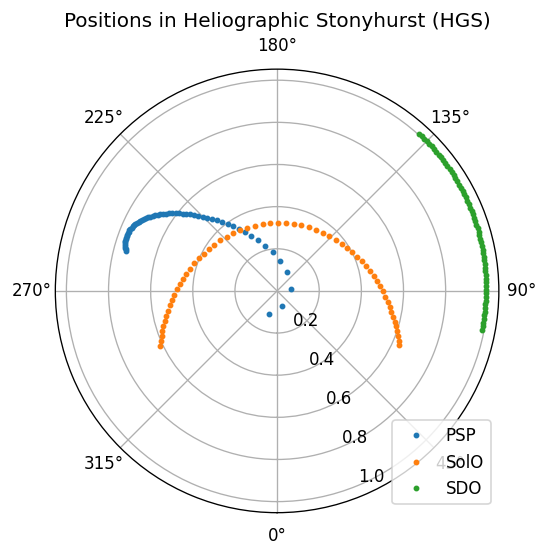

In [102]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='polar')

# Transform to HGS
psp_coord_hgs = psp_coord.heliocentricinertial
solo_coord_hgs = solo_coord.heliocentricinertial
sdo_coord_hgs = sdo_coord.heliocentricinertial


ax.plot(psp_coord_hgs.lon.to('rad'), psp_coord_hgs.distance,
        '.', markersize=5, label='PSP')
ax.plot(solo_coord_hgs.lon.to('rad'), solo_coord_hgs.distance,
        '.', markersize=5, label='SolO')
ax.plot(sdo_coord_hgs.lon.to('rad'), sdo_coord_hgs.distance,
        '.', markersize=5, label='SDO')


ax.legend(loc='lower right')
ax.set_theta_zero_location("S")
ax.set_title('Positions in Heliographic Stonyhurst (HGS)')